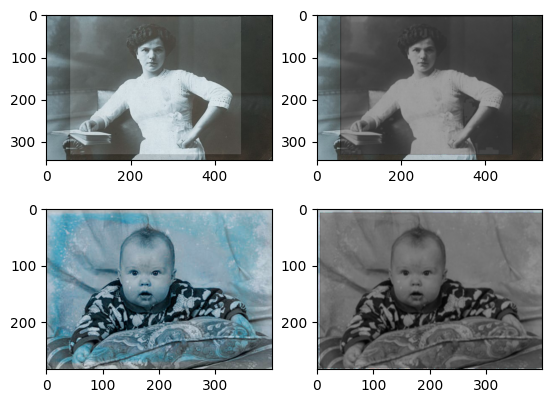

In [1]:
# C20483462 Jamie Heffernan | Image Processing Assignment 1
#
# Algorithm Overview
# 1. Isolate damaged and undamaged areas of the images
# 2. Isolate damaged areas in YUV colour space 
# 3. Equalise damaged area histograms for more even distribution
# 4. Apply Laplacian Kernel to sharpen centre areas and blue edges
# 5. Combine damaged and undamaged areas
#
# Limitations
# The algorithm was designed with two specific images in mind and may not be suitable for all images as the algorithm lacks adaptive thresholding mechanisms, potentially affecting its performance on newer images.
# The algorithm heavily relies on gradient-based transitions, making it sensitive to image quality and noise, which may lead to inaccurate identification of damaged areas.
# The height and width of the images provided play a large part in the time complexity of our algorithm as the bigger the image the longer it will take to restore. O(height*width)
#
# References : 
# https://docs.opencv.org/4.x/d0/d86/tutorial_py_image_arithmetics.html
# https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
# https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html
# https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04

import cv2
import numpy as np
from matplotlib import pyplot as plt

def process_image(I: np.ndarray) -> np.ndarray:
    # Convert the image to grayscale
    grey = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    # Calculate average intensity value for rows & columns
    rowIntensity = np.mean(grey, axis=1)
    columnIntensity = np.mean(grey, axis=0)

    # Calculate the gradient along rows to find transitions
    rowGradient = np.gradient(rowIntensity)
    colGradient = np.gradient(columnIntensity)

    # Set threshold to find transitions
    rowThreshold = np.max(np.abs(rowGradient)) * 0.12
    columnThreshold = np.max(np.abs(colGradient)) * 0.12

    # Find changes in intensity along rows and columns
    transitionRows = np.where(np.abs(rowGradient) > rowThreshold)[0]
    transitionColumns = np.where(np.abs(colGradient) > columnThreshold)[0]

    # Identify undamaged areas of the image
    undamagedTop = np.min(transitionRows)
    undamagedBottom = np.max(transitionRows)
    undamagedLeft = np.min(transitionColumns)
    undamagedRight = np.max(transitionColumns)

    # Create a binary mask and then isolate the undamaged area
    damagedMask = np.zeros_like(I, dtype=np.uint8)
    damagedMask[undamagedTop:undamagedBottom, undamagedLeft:undamagedRight] = 255

    # Flip the damaged mask to isolate the undamaged area
    undamagedMask = cv2.bitwise_not(damagedMask)

    # Separate the damaged and undamaged parts of the image
    undamagedArea = cv2.bitwise_and(I, undamagedMask)
    damagedArea = cv2.bitwise_and(I, damagedMask)

    # Convert jpg to YUV
    YUV = cv2.cvtColor(damagedArea, cv2.COLOR_BGR2YUV)

    # Extract the individual YUV values from the image
    Y, U, V = cv2.split(YUV) # We isolate the U and V channels as they highlight the damaged areas in blue

    # Equalize the U and V channels to more evenly distribute the damage
    eqU = cv2.equalizeHist(U)
    eqV = cv2.equalizeHist(V)

    # Threshold the U and V channels to create masks for damaged areas
    _, maskU = cv2.threshold(eqU, 10, 250, cv2.THRESH_BINARY)
    _, maskV = cv2.threshold(eqV, 10, 250, cv2.THRESH_BINARY)

    # Ensure the masks have the same shape as U and V
    maskU = cv2.resize(maskU, (U.shape[1], U.shape[0]))
    maskV = cv2.resize(maskV, (V.shape[1], V.shape[0]))

    # Invert the masks
    invertedMaskU = cv2.bitwise_not(maskU)
    invertedMaskV = cv2.bitwise_not(maskV)

    # Subtract the inverted masks from the original U and V channels
    improvedU = cv2.subtract(U, invertedMaskU)
    improvedV = cv2.subtract(V, invertedMaskV)

    # Merge the improved channels with the original Y to get the improved image
    improvedYUV = cv2.merge([Y, improvedU, improvedV])

    # Convert back to BGR then to Greyscale
    improvedBGR = cv2.cvtColor(improvedYUV, cv2.COLOR_YUV2RGB)
    improvedGS = cv2.cvtColor(improvedBGR, cv2.COLOR_RGB2GRAY)

    # Define a Laplacian kernel for sharpening the image while blending damaged edges
    kernel = np.array([[1, 2, 1],
                       [1, 4, 1],
                       [1, 2, 1]]) / 20.0

    # Apply the kernel
    sharpened = cv2.filter2D(improvedGS, -1, kernel)

    # Convert the image back to the original colour space
    final = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)

    #Combine undamaged area with the corrected damaged area
    restored = cv2.bitwise_or(undamagedArea, final)

    return restored

# Please DO NOT change any of the code below. All modifications to this template should
# occur inside the **process_image** function

fig, axs = plt.subplots(2, 2)
original_faded = cv2.imread('./faded.jpg')
improved_faded = process_image(original_faded)

axs[0, 0].imshow(original_faded)
axs[0, 1].imshow(improved_faded)

original_damaged = cv2.imread('./damaged.jpg')
improved_damaged = process_image(original_damaged)

axs[1, 0].imshow(original_damaged)
axs[1, 1].imshow(improved_damaged)

plt.show()
